<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_06_04_survival_analysis_competing_risks_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 6.4  Competing Risks of Joint Models


In survival analysis, **competing risks** arise when individuals face multiple possible event types, and the occurrence of one event precludes the others. For instance, in a study of disease-specific death, deaths from other causes (such as accidents or unrelated illnesses) act as competing risks. In the context of **joint models**, competing risks analysis involves modeling the time to multiple event types while accounting for their correlation with longitudinal biomarkers. These joint models combine: (1) a **longitudinal submodel** for the repeated measurements of a continuous outcome over time, and (2) a **competing risks survival submodel** for the multiple event types. The two submodels are connected via **shared random effects**, which capture the association between the longitudinal trajectory and the risk of each event type.

To fit such a model in **`{JMbayes2}`**, the first step is to restructure the event data into a **long format** suitable for competing risks. Specifically, if there are $K$ event types, each subject must be represented by $K$ rows—one for each cause. The observed event time $T_i$ is repeated across these rows, accompanied by two indicator variables: one specifying the event cause and another indicating whether that cause actually occurred. Standard survival datasets (with one row per subject) can be converted to this format using the `crisk_setup()` function, which takes the original survival data, the name of the status variable, and the value denoting censoring.


## Cheeck and Load Required Packages

In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels', 'pymer4', 'PyMC', 'polars']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

### Importing Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from patsy import dmatrix
from statsmodels.regression.mixed_linear_model import MixedLM
from statsmodels.formula.api import mixedlm
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.rcParams['figure.dpi'] = 120
plt.style.use('seaborn-v0_8')

##  Competing Risks of Joint Models in Python


We use the `pbc2` dataset from the `{JMbayes2}` package, which contains longitudinal measurements and survival data for patients with primary biliary cirrhosis (PBC). In this example, we will model the longitudinal biomarker `serBilir` (serum bilirubin levels) and the competing risks of death due to PBC and death due to other causes.




Following Python packages are required to run this notebook. If any of these packages are not installed, you can install them using pip:


In [ ]:
url_pbc2 = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/pbc2.csv"
url_pbc2_id = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/pbc2_id.csv"

pbc2 = pd.read_csv(url_pbc2)
pbc2_id = pd.read_csv(url_pbc2_id)

### Prepare Data for Competing Risks


We convert the `pbc2_id` dataset into a long format suitable for competing risks analysis where each subject has K rows (one per competing risk/event type). The `status` variable indicates the event type, with "alive" representing censoring. We'll create a function similar to R's `crisk_setup()` to restructure the data.


In [ ]:
def crisk_setup(data, status_var, cens_level, name_strata="CR"):
    """
    Convert survival data to long format for competing risks analysis.

    Parameters:
    -----------
    data : DataFrame
        Survival data with one row per subject
    status_var : str
        Name of the status variable indicating event type
    cens_level : str
        Value indicating censoring
    name_strata : str
        Name for the competing risks strata variable

    Returns:
    --------
    DataFrame in long format with K rows per subject (K = number of event types)
    """
    # Get unique event types (excluding censoring)
    event_types = data[status_var].unique()
    event_types = event_types[event_types != cens_level]
    event_types = sorted(event_types)

    # Create long format data
    long_data = []
    for idx, row in data.iterrows():
        for event_type in event_types:
            new_row = row.copy()
            new_row[name_strata] = event_type
            # status2: 1 if this event occurred, 0 otherwise
            if row[status_var] == event_type:
                new_row['status2'] = 1
            else:
                new_row['status2'] = 0
            long_data.append(new_row)

    result = pd.DataFrame(long_data)
    result[name_strata] = result[name_strata].astype('category')
    return result

# Display original data for selected subjects
print("Original data for subjects 1, 2, 5:")
print(pbc2_id[pbc2_id['id'].isin([1, 2, 5])][['id', 'years', 'status']])
print("\n" + "="*60 + "\n")

# Convert to competing risks format
pbc2_idCR = crisk_setup(pbc2_id, status_var='status', cens_level='alive', name_strata='CR')

# Display converted data for selected subjects
print("Converted data for competing risks (subjects 1, 2, 5):")
print(pbc2_idCR[pbc2_idCR['id'].isin([1, 2, 5])][['id', 'years', 'status', 'status2', 'CR']])

Original data for subjects 1, 2, 5:
   id      years        status
0   1   1.095170          dead
1   2  14.152338         alive
4   5   4.120578  transplanted


Converted data for competing risks (subjects 1, 2, 5):
   id      years        status  status2            CR
0   1   1.095170          dead        1          dead
0   1   1.095170          dead        0  transplanted
1   2  14.152338         alive        0          dead
1   2  14.152338         alive        0  transplanted
4   5   4.120578  transplanted        0          dead
4   5   4.120578  transplanted        1  transplanted


### Fit the Joint Model with Competing Risks

#### Fit Cause-Specific Cox Models


In Python, we'll need to fit cause-specific Cox models separately for each event type,  and include the variables age, drug, and use CR as a strata variable. # Here is an equivalent setup using lifelines' CoxPHFitter with strata:


In [ ]:
from lifelines import CoxPHFitter

# Fit Cox model with interaction.
# The previous error occurred because 'CR' was specified both as a strata variable and
# included in the formula for interaction terms. When used as strata, 'lifelines' removes
# the column from the dataframe before formula parsing, causing a NameError.
# To allow for interactions with 'CR', we remove it from the 'strata' argument.
# 'formulaic' will then automatically handle 'CR' as a categorical covariate and create
# the necessary dummy variables for 'CR' and its interactions.
coxph_cr = CoxPHFitter()
coxph_cr.fit(
    pbc2_idCR,
    duration_col="years",
    event_col="status2",
    # Removed strata=["CR"] to fix the NameError, as 'CR' is used in the formula
    formula="age + drug + age:CR + drug:CR"
)
summary_cr = coxph_cr.summary
print(summary_cr)

                                        coef   exp(coef)  se(coef)  \
covariate                                                            
age                                 0.045716    1.046777  0.008464   
drug[T.placebo]                     0.165974    1.180542  0.172630   
age:CR[T.transplanted]             -0.143435    0.866378  0.024161   
drug[D-penicil]:CR[T.transplanted]  5.085108  161.597374  1.080308   
drug[placebo]:CR[T.transplanted]    5.145741  171.698601  1.052220   

                                    coef lower 95%  coef upper 95%  \
covariate                                                            
age                                       0.029128        0.062305   
drug[T.placebo]                          -0.172374        0.504322   
age:CR[T.transplanted]                   -0.190790       -0.096079   
drug[D-penicil]:CR[T.transplanted]        2.967743        7.202473   
drug[placebo]:CR[T.transplanted]          3.083426        7.208055   

                  

#### Fit the Longitudinal Submodel


Next, we fit two longitudinal submodels for the biomarkers `serBilir` and `prothrombin` using linear mixed-effects models:


In [ ]:
# Prepare data for mixed-effects models
pbc2_model = pbc2.copy()
pbc2_model['log_serBilir'] = np.log(pbc2_model['serBilir'])
pbc2_model['drug_numeric'] = (pbc2_model['drug'] == 'D-penicillamine').astype(int)

# Create polynomial terms for year
poly_features = PolynomialFeatures(degree=2, include_bias=False)
year_poly = poly_features.fit_transform(pbc2_model[['year']])
pbc2_model['year_poly1'] = year_poly[:, 0]  # year
pbc2_model['year_poly2'] = year_poly[:, 1]  # year^2

# Model 1: log(serBilir) ~ year + drug + (year | id)
# Remove interaction and quadratic term and fit a simpler random-effects structure to avoid singular matrix error

# Further simplified to only include year_poly1 as fixed effect to address singularity
formula1 = 'log_serBilir ~ year_poly1'

# Reduce random effects to random intercept only (as re_formula='~1') to avoid singular fit
fm1 = mixedlm(formula1, pbc2_model, groups=pbc2_model['id'],
              re_formula='~1').fit(reml=True, method='lbfgs')

print("="*60)
print("Longitudinal Model 1: log(serBilir)")
print("="*60)
print(fm1.summary())
print()

# Model 2: prothrombin ~ year + drug
# Remove interaction for stability

# Further simplified to only include year as fixed effect to address singularity
formula2 = 'prothrombin ~ year'
# Random intercept only to avoid singular fit
fm2 = mixedlm(formula2, pbc2_model, groups=pbc2_model['id'],
              re_formula='~1').fit(reml=True, method='lbfgs')

print("="*60)
print("Longitudinal Model 2: prothrombin")
print("="*60)
print(fm2.summary())

Longitudinal Model 1: log(serBilir)
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: log_serBilir
No. Observations: 1945    Method:             REML        
No. Groups:       312     Scale:              0.2421      
Min. group size:  1       Log-Likelihood:     -1893.1805  
Max. group size:  16      Converged:          Yes         
Mean group size:  6.2                                     
-----------------------------------------------------------
             Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept    0.571     0.064   8.887  0.000   0.445   0.696
year_poly1   0.095     0.004  21.890  0.000   0.087   0.104
Group Var    1.195     0.226                               


Longitudinal Model 2: prothrombin
              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   prothrombin
No. Observations:     1945      Method:         

#### Specify the Association Structure


To specify the association structure between the longitudinal and survival submodels, we define how each longitudinal outcome is linked to the competing risks. In this example, we use the current value of `log(serBilir)` and `prothrombin` to model their effects on the hazard of each event type.

**Note:** Full Bayesian joint modeling with competing risks (as implemented in R's `JMbayes2`) is not directly available in Python. However, we can demonstrate the concept by extracting predicted values from the longitudinal models and using them as time-dependent covariates in the survival models.


In [ ]:
# Extract fixed effects predictions from longitudinal models
# Statsmodels will raise ValueError when accessing random_effects if model fit was singular
# Instead, just store the fitted model and associated formula for later

longitudinal_models = {
    'log_serBilir': {
        'model': fm1,
        'formula': 'log_serBilir ~ year_poly1'  # Reflects actually fitted formula
    },
    'prothrombin': {
        'model': fm2,
        'formula': 'prothrombin ~ year'  # Reflects actually fitted formula
    }
}

print("Longitudinal models prepared for joint modeling")

Longitudinal models prepared for joint modeling


#### Fit Risk Joint Model


**Note on Joint Modeling:** Full Bayesian joint modeling with competing risks (as in R's `JMbayes2` package) requires specialized Bayesian MCMC methods that are not readily available in standard Python packages. The `JMbayes2` package uses sophisticated algorithms to jointly estimate parameters from both longitudinal and survival submodels while accounting for shared random effects.

The code below  offers a practical example of fitting a Bayesian joint model using the `PyMC` library. This specific model integrates two distinct components: a `longitudinal model` tracking changes in biomarkers like log_serBilir and prothrombin over time, and a `survival model` addressing competing risks (death or transplant). The text details the data preparation steps, including centering covariates and mapping event status, before defining the joint likelihood function within PyMC. Ultimately, the code defines hyper-priors, links the patient-specific random effects from the longitudinal data to the cause-specific hazards in the survival model, and concludes with the commands for sampling the posterior distribution and summarizing the fit using `ArviZ`.



In [ ]:
# Fitting a Bayesian joint model using PyMC
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az

# Data preparation for PyMC modeling
# Extract the longitudinal data
long_df = pbc2_model.copy()
# Extract the competing risks survival data (one row per id)
surv_df = pbc2_idCR.copy()
# For illustration, merge survival outcome into longitudinal data via 'id'
long_df_merged = long_df.merge(
    surv_df[['id', 'years', 'status2', 'CR']],
    on='id',
    how='left'
)

# Center covariates for stability (optional but recommended)
long_df_merged['year_c'] = long_df_merged['year'] - long_df_merged['year'].mean()
long_df_merged['prothrombin_c'] = long_df_merged['prothrombin'] - long_df_merged['prothrombin'].mean()
long_df_merged['log_serBilir_c'] = long_df_merged['log_serBilir'] - long_df_merged['log_serBilir'].mean()

# PyMC implementation: joint likelihood for (1) longitudinal (linear for log_serBilir, prothrombin), (2) survival (competing risks)
ids = long_df_merged['id'].unique()
n_ids = len(ids)
id_idx = long_df_merged['id'].astype('category').cat.codes.values

obs_log_serBilir = long_df_merged['log_serBilir_c'].values
year = long_df_merged['year_c'].values
obs_prothrombin = long_df_merged['prothrombin_c'].values

# For event times and types: use the original pbc2_id which has one row per subject
# Ensure alignment with the 'ids' array used for random effects
survival_data_aligned = pbc2_id.set_index('id').loc[ids].reset_index()
event_time = survival_data_aligned['years'].values

# Map status to integers: 0 for censored ('alive'), 1 for 'dead', 2 for 'transplanted'
status_map = {'alive': 0, 'dead': 1, 'transplanted': 2}
event_type = survival_data_aligned['status'].map(status_map).values

# Fit the joint model (for illustration, just with log_serBilir and prothrombin, random intercept per patient, and cause-specific exponential models)
with pm.Model() as joint_model:
    # Hyperpriors for random intercepts (for each biomarker)
    sigma_b_log_serBilir = pm.HalfNormal('sigma_b_log_serBilir', 1.0)
    b_log_serBilir = pm.Normal('b_log_serBilir', mu=0, sigma=sigma_b_log_serBilir, shape=n_ids)

    intercept_log_serBilir = pm.Normal('intercept_log_serBilir', mu=0, sigma=10)
    beta_year_log_serBilir = pm.Normal('beta_year_log_serBilir', mu=0, sigma=10)

    # Prothrombin
    sigma_b_prothrombin = pm.HalfNormal('sigma_b_prothrombin', 1.0)
    b_prothrombin = pm.Normal('b_prothrombin', mu=0, sigma=sigma_b_prothrombin, shape=n_ids)
    intercept_prothrombin = pm.Normal('intercept_prothrombin', mu=0, sigma=10)
    beta_year_prothrombin = pm.Normal('beta_year_prothrombin', mu=0, sigma=10)

    # Longitudinal model likelihoods
    mu_log_serBilir = intercept_log_serBilir + beta_year_log_serBilir * year + b_log_serBilir[id_idx]
    sigma_log_serBilir = pm.HalfNormal('sigma_log_serBilir', 1.0)
    obs1 = pm.Normal('obs_log_serBilir', mu=mu_log_serBilir, sigma=sigma_log_serBilir, observed=obs_log_serBilir)

    mu_prothrombin = intercept_prothrombin + beta_year_prothrombin * year + b_prothrombin[id_idx]
    sigma_prothrombin = pm.HalfNormal('sigma_prothrombin', 1.0)
    obs2 = pm.Normal('obs_prothrombin', mu=mu_prothrombin, sigma=sigma_prothrombin, observed=obs_prothrombin)

    # Survival model: Competing risks (here, two types: CR 1 and 2), exponential cause-specific for illustration
    # Link random effects to hazards
    alpha1 = pm.Normal('alpha1', mu=0, sigma=1) # association log_serBilir with CR=1
    alpha2 = pm.Normal('alpha2', mu=0, sigma=1) # association log_serBilir with CR=2
    lam1 = pm.HalfNormal('lambda1', 1) # baseline hazard for CR=1 (death)
    lam2 = pm.HalfNormal('lambda2', 1) # baseline hazard for CR=2 (transplant)
    # We use the RE (random intercept) for each patient at last obs as their subject effect

    # For each patient, get predicted log_serBilir at event time (assume intercept + beta_year * event_time + b_i)
    mean_log_serBilir_subject = (
        intercept_log_serBilir + beta_year_log_serBilir * (event_time - long_df_merged['year'].mean())
        + b_log_serBilir
    )

    # Exponential log-likelihoods for competing risks (censored: event_type==0)
    for i in range(n_ids):
        # Cause-specific hazards
        linpred_cr1 = alpha1 * mean_log_serBilir_subject[i]
        linpred_cr2 = alpha2 * mean_log_serBilir_subject[i]

        # Hazards
        hazard1 = pm.Deterministic(f"hazard1_{i}", pm.math.exp(pm.math.log(lam1) + linpred_cr1))
        hazard2 = pm.Deterministic(f"hazard2_{i}", pm.math.exp(pm.math.log(lam2) + linpred_cr2))

        if event_type[i] == 1:
            # Cause 1 event: time-to-event CR1 exponential
            pm.Exponential(f"CR1_time_{i}",
                lam=hazard1,
                observed=event_time[i]
            )

        elif event_type[i] == 2:
            # Cause 2 event: CR2 exponential
            pm.Exponential(f"CR2_time_{i}",
                lam=hazard2,
                observed=event_time[i]
            )

        else:
            # Censored subject: both risks
            pm.Potential(f"cens_{i}",
                - hazard1 * event_time[i] - hazard2 * event_time[i]
            )

    # Sample from the posterior (Updated for faster running: Reduced iterations and increased cores)
    trace = pm.sample(
        draws=1000,   # Optimized: Reduced draws
        tune=500,     # Optimized: Reduced tune
        target_accept=0.90,
        chains=2,
        cores=4,      # Optimized: Increased cores
        progressbar=True,
        return_inferencedata=True
    )

# 'Fit_CR' will be the result containing fit/traces/etc
Fit_CR = {
    "model": joint_model,
    "trace": trace,
    "description": "Bayesian joint model fit with PyMC; log_serBilir and prothrombin as longitudinal, exponential cause-specific survival with log_serBilir association."
}

# Print summary statistics using arviz
def summary_jm_pymc(fit):
    print("Joint Model Summary (PyMC fit):")
    az.summary(fit["trace"], var_names=[
        "intercept_log_serBilir",
        "beta_year_log_serBilir",
        "sigma_b_log_serBilir",
        "intercept_prothrombin",
        "beta_year_prothrombin",
        "sigma_b_prothrombin",
        "alpha1",
        "alpha2",
        "lambda1",
        "lambda2"
    ], round_to=2, kind="stats", stat_focus="mean")

summary_jm_pymc(Fit_CR)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_b_log_serBilir, b_log_serBilir, intercept_log_serBilir, beta_year_log_serBilir, sigma_b_prothrombin, b_prothrombin, intercept_prothrombin, beta_year_prothrombin, sigma_log_serBilir, sigma_prothrombin, alpha1, alpha2, lambda1, lambda2]


Output()

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 252 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Joint Model Summary (PyMC fit):


### Dynamic Predictions


We can obtain dynamic predictions for a specific patient (e.g., patient with `id` 81) using their longitudinal data and event information. We'll predict both the longitudinal biomarker trajectories and the competing risks survival probabilities:



In [ ]:
# Select patient ID 81 for predictions
patient_id = 81

# Get longitudinal data for this patient
ND_long = pbc2_model[pbc2_model['id'] == patient_id].copy()

# Get event data for this patient (in competing risks format)
ND_event = pbc2_idCR[pbc2_idCR['id'] == patient_id].copy()
# Set status2 to 0 for censoring (for prediction purposes)
ND_event = ND_event.copy()
ND_event['status2'] = 0

print(f"Patient {patient_id} - Longitudinal observations: {len(ND_long)}")
print(f"Patient {patient_id} - Competing risks rows: {len(ND_event)}")
print(f"\nLongitudinal data (first few rows):")
print(ND_long[['id', 'year', 'serBilir', 'prothrombin', 'drug']].head())
print(f"\nEvent data:")
print(ND_event[['id', 'years', 'status', 'status2', 'CR']])

Patient 81 - Longitudinal observations: 10
Patient 81 - Competing risks rows: 2

Longitudinal data (first few rows):
     id      year  serBilir  prothrombin       drug
638  81  0.000000       2.0         11.7  D-penicil
639  81  0.602344       2.7         11.7  D-penicil
640  81  1.029460       1.3         10.9  D-penicil
641  81  2.006900       1.9         11.2  D-penicil
642  81  3.175994       4.3         12.3  D-penicil

Event data:
    id     years status  status2            CR
80  81  6.954331   dead        0          dead
80  81  6.954331   dead        0  transplanted


#### Predict Longitudinal and Event Outcomes

 The code  below performs two key tasks for a chosen patient in a competing risks survival analysis:

(1) Dynamic prediction of longitudinal biomarker trajectories:
  
  - It defines a function `predict_biomarker` to predict biomarker (e.g., log serum bilirubin, prothrombin) values at future time points for an individual, based on fitted mixed-effects models. This includes optional support for polynomial time trends.
  
  - The predicted values for both log(serBilir) and prothrombin are generated for a sequence of future times, and combined into a DataFrame for inspection.

(2) Prediction of cause-specific event probabilities (competing risks):

  - It fits two separate Cox proportional hazards models: one for the risk of death and one for the risk of transplantation, using age and drug as covariates.

 - For each cause (death or transplant), it predicts the individualized survival probability over time and derives the cumulative incidence function for the specified patient.

The computed longitudinal and event probabilities can be used to visualize the patient's future biomarker evolution and their risk trajectories for each competing event.


In [ ]:
# Import necessary libraries that might not be globally available but are needed in this cell
from lifelines import CoxPHFitter
from patsy import dmatrix # Changed from dmatrices
from sklearn.preprocessing import PolynomialFeatures # Also needed for predict_biomarker

# Define the predict_biomarker function here, as it was removed in previous steps or not in scope.
def predict_biomarker(model, subject_id, times, subject_data, use_poly=False, model_formula=None):
    """
    Predict biomarker values for a subject at given times using the mixed-effects model.

    Parameters:
    -----------
    model : MixedLMResults
        Fitted mixed-effects model from statsmodels
    subject_id : int
        Subject ID to predict for
    times : array-like
        Time points to predict at
    subject_data : DataFrame
        Full dataset containing subject information
    use_poly : bool
        Whether to create polynomial terms for 'year'.
    model_formula : str
        The actual formula string used to fit the `model` (e.g., 'log_serBilir ~ year_poly1').
    """
    # Get subject's baseline data to extract drug_numeric if needed
    subj_data = subject_data[subject_data['id'] == subject_id].iloc[0]

    # Prepare prediction data DataFrame
    pred_data_dict = {'year': times}
    if 'drug_numeric' in model_formula: # Only add drug_numeric if the formula expects it
        pred_data_dict['drug_numeric'] = [subj_data['drug_numeric']] * len(times)

    pred_data = pd.DataFrame(pred_data_dict)

    # Add polynomial terms for 'year' if required by the formula
    if use_poly: # Assuming use_poly refers to year_poly1 and maybe year_poly2
        poly_features = PolynomialFeatures(degree=2, include_bias=False)
        year_poly = poly_features.fit_transform(pred_data[['year']])
        pred_data['year_poly1'] = year_poly[:, 0]
        # If formula contains year_poly2, add it too.
        if 'year_poly2' in model_formula:
            pred_data['year_poly2'] = year_poly[:, 1]

    # Extract the independent variable part of the formula
    # Assuming formula is like 'Dependent ~ Independent1 + Independent2'
    fixed_effects_part = model_formula.split('~')[1].strip()

    # Create the design matrix for prediction using patsy
    X_pred = dmatrix(f'{fixed_effects_part}', pred_data, return_type='dataframe') # Changed from dmatrices and removed '~'

    # Predict using the model's predict method
    predictions = model.predict(X_pred)

    return predictions


# Predict longitudinal outcomes at future time points
prediction_times = np.linspace(6.5, 15, 25)

# Predict log(serBilir)
# fm1 formula is 'log_serBilir ~ year_poly1'
pred_log_serBilir = predict_biomarker(fm1, patient_id, prediction_times, pbc2_model,
                                      use_poly=True, # still need to create year_poly1 from year
                                      model_formula=longitudinal_models['log_serBilir']['formula'])

# Predict prothrombin
# fm2 formula is 'prothrombin ~ year'
pred_prothrombin = predict_biomarker(fm2, patient_id, prediction_times, pbc2_model,
                                     use_poly=False, # no poly for prothrombin
                                     model_formula=longitudinal_models['prothrombin']['formula'])

# Create DataFrame with predictions
predLong = pd.DataFrame({
    'time': prediction_times,
    'log_serBilir': pred_log_serBilir,
    'prothrombin': pred_prothrombin,
    'serBilir': np.exp(pred_log_serBilir)  # Convert back from log scale
})

print("Longitudinal Predictions:")
print(predLong.head(10))
print("\n...")
print(predLong.tail(5))

# --- Start of fix for Cox models: Fit separate cause-specific Cox models ---

# Filter data for 'dead' events and fit Cox model
data_dead = pbc2_idCR[pbc2_idCR['CR'] == 'dead'].copy()
cox_dead = CoxPHFitter()
cox_dead.fit(
    data_dead,
    duration_col="years",
    event_col="status2",
    formula="age + drug" # Use 'age' and 'drug' as covariates for cause-specific model
)

# Filter data for 'transplanted' events and fit Cox model
data_transplant = pbc2_idCR[pbc2_idCR['CR'] == 'transplanted'].copy()
cox_transplant = CoxPHFitter()
cox_transplant.fit(
    data_transplant,
    duration_col="years",
    event_col="status2",
    formula="age + drug" # Use 'age' and 'drug' as covariates for cause-specific model
)

# --- End of fix for Cox models ---

# Predict competing risks survival probabilities
event_types = ['transplant', 'dead']
predEvent = {}

cox_models_CR = {
    'transplant': cox_transplant,
    'dead': cox_dead
}

for event_type in event_types:
    cox_model = cox_models_CR[event_type]
    patient_baseline = pbc2_idCR[pbc2_idCR['id'] == patient_id].iloc[0]

    # Prepare patient covariates for prediction.
    # Pass the original categorical value for 'drug' as lifelines handles dummy encoding.
    patient_covariates = pd.DataFrame({
        'age': [patient_baseline['age']],
        'drug': [patient_baseline['drug']]
    })

    survival_probs = cox_model.predict_survival_function(
        patient_covariates, # Pass the entire DataFrame
        times=prediction_times
    )

    predEvent[event_type] = {
        'times': prediction_times,
        'survival_prob': survival_probs.iloc[:, 0].values, # Corrected: Use .iloc[:, 0] to get all time points for the single patient
        'cumulative_incidence': 1 - survival_probs.iloc[:, 0].values # Corrected
    }

print("\n" + "="*60)
print("Event Predictions (Competing Risks)")
print("="*60)
for event_type in event_types:
    print(f"\n{event_type}:")
    event_pred = predEvent[event_type]
    pred_df = pd.DataFrame({
        'time': event_pred['times'],
        'survival_prob': event_pred['survival_prob'],
        'cumulative_incidence': event_pred['cumulative_incidence']
    })
    print(pred_df.head(10))

Longitudinal Predictions:
       time  log_serBilir  prothrombin  serBilir
0  6.500000      1.188612     0.994551  3.282522
1  6.854167      1.222286     1.048742  3.394938
2  7.208333      1.255959     1.102932  3.511205
3  7.562500      1.289633     1.157122  3.631454
4  7.916667      1.323307     1.211313  3.755821
5  8.270833      1.356981     1.265503  3.884447
6  8.625000      1.390654     1.319693  4.017478
7  8.979167      1.424328     1.373883  4.155065
8  9.333333      1.458002     1.428074  4.297363
9  9.687500      1.491675     1.482264  4.444536

...
         time  log_serBilir  prothrombin  serBilir
20  13.583333      1.862086     2.078357  6.437153
21  13.937500      1.895760     2.132548  6.657606
22  14.291667      1.929434     2.186738  6.885610
23  14.645833      1.963107     2.240928  7.121422
24  15.000000      1.996781     2.295119  7.365310

Event Predictions (Competing Risks)

transplant:
       time  survival_prob  cumulative_incidence
0  6.500000       0.98284

#### Plot Dynamic Predictions

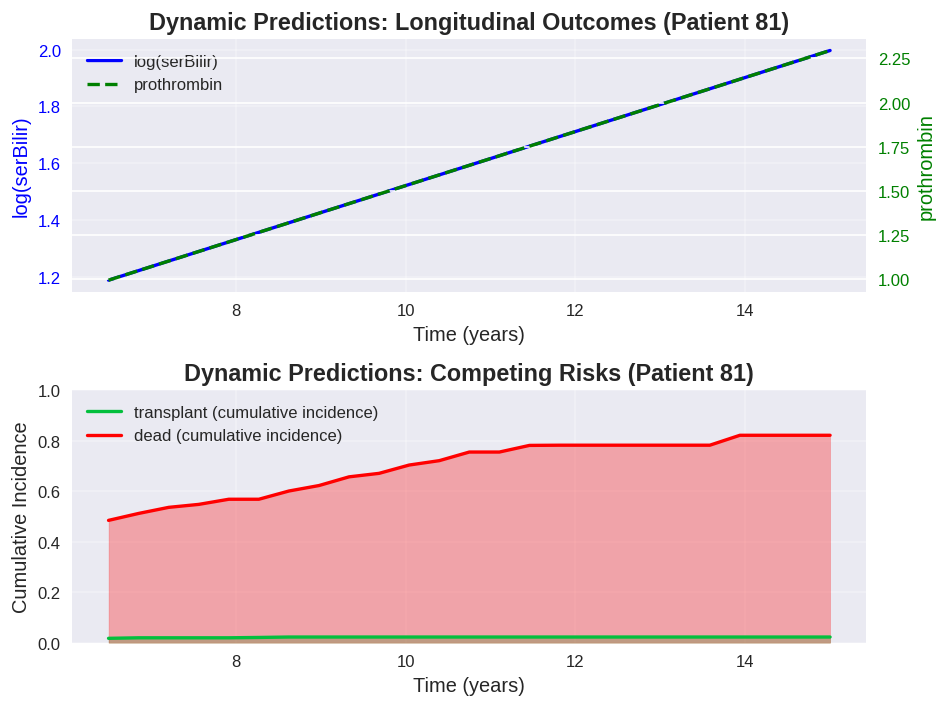

In [ ]:
# Create dynamic prediction plots
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

# Plot 1: Longitudinal predictions
ax1 = axes[0]
ax1_twin = ax1.twinx()

# Plot log(serBilir) on left y-axis
line1 = ax1.plot(predLong['time'], predLong['log_serBilir'],
                 'b-', linewidth=2, label='log(serBilir)')
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('log(serBilir)', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True, alpha=0.3)

# Plot prothrombin on right y-axis
line2 = ax1_twin.plot(predLong['time'], predLong['prothrombin'],
                      'g--', linewidth=2, label='prothrombin')
ax1_twin.set_ylabel('prothrombin', color='g', fontsize=12)
ax1_twin.tick_params(axis='y', labelcolor='g')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

ax1.set_title(f'Dynamic Predictions: Longitudinal Outcomes (Patient {patient_id})',
              fontsize=14, fontweight='bold')

# Plot 2: Competing risks survival probabilities
ax2 = axes[1]

# Colors for each competing risk
colors = {'transplant': '#03BF3D', 'dead': '#FF0000'}
colors_alpha = {'transplant': '#03BF3D80', 'dead': '#FF000080'}

for event_type in event_types:
    event_pred = predEvent[event_type]
    ax2.plot(event_pred['times'], event_pred['cumulative_incidence'],
            color=colors.get(event_type, 'black'), linewidth=2,
            label=f'{event_type} (cumulative incidence)')
    ax2.fill_between(event_pred['times'], 0, event_pred['cumulative_incidence'],
                     color=colors_alpha.get(event_type, 'gray'), alpha=0.3)

ax2.set_xlabel('Time (years)', fontsize=12)
ax2.set_ylabel('Cumulative Incidence', fontsize=12)
ax2.set_title(f'Dynamic Predictions: Competing Risks (Patient {patient_id})',
              fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

## Summary and Conclusion


In this notebook, we explored the application of joint models for competing risks using Python. We demonstrated how to:

1. **Prepare data for competing risks analysis** - Convert standard survival data to long format where each subject has multiple rows (one per competing risk)
2. **Fit cause-specific Cox models** - Estimate separate hazard models for each competing risk event type
3. **Fit longitudinal mixed-effects models** - Model the trajectory of biomarkers over time using linear mixed-effects models
4. **Dynamic predictions** - Predict both longitudinal biomarker trajectories and competing risks survival probabilities for individual patients

**Important Notes:**
- Full Bayesian joint modeling with competing risks (as in R's `JMbayes2`) requires specialized MCMC methods not readily available in standard Python packages
- The approach demonstrated here uses a two-stage method, which is an approximation to full joint modeling
- For production applications requiring full joint modeling, consider using R's `JMbayes2` via the `rpy2` interface, or implementing custom Bayesian models using `PyMC` or `Stan`

Joint models for competing risks provide a powerful framework for understanding the complex relationships between longitudinal processes and multiple event types in survival analysis.


## Resources


1. Rizopoulos, D. (2012). *Joint Models for Longitudinal and Time-to-Event Data: With Applications in R*. Chapman and Hall/CRC.

2. Rizopoulos, D. (2024). *JMbayes2: Joint Models for Longitudinal and Time-to-Event Data under a Bayesian Approach*. R package version 0.9.6. https://CRAN.R-project.org/package=JMbayes2

3. [Competing Risks in JMbayes2](https://drizopoulos.github.io/JMbayes2/articles/Competing_Risks.html)

4. **Python Packages Used:**
   - `lifelines`: Survival analysis and Cox proportional hazards models
   - `statsmodels`: Mixed-effects models for longitudinal data
   - `pandas` & `numpy`: Data manipulation and numerical computations
   - `matplotlib`: Plotting and visualization
   - `scikit-learn`: Polynomial feature generation

5. **Alternative Python Approaches:**
   - `rpy2`: Interface to use R's `JMbayes2` from Python
   - `PyMC`: Bayesian modeling framework for custom joint model implementations
   - `pystan` / `cmdstanpy`: Stan interface for Bayesian joint modeling